# PyTorch

PyTorch 是一個由 Meta AI 主導開發，現由 Linux 基金會託管的頂尖開源機器學習框架。它憑藉其直觀的 Pythonic 介面、由動態計算圖賦予的高度靈活性，以及從研究原型到生產部署的無縫路徑，在全球學術界與工業界確立了其領導地位。

#### 核心架構 (Core Architecture)

PyTorch 的設計圍繞兩大核心組件：

1.  **張量計算與 GPU 加速 (Tensor Computing with GPU Acceleration)**
    PyTorch 的核心資料結構為**張量 (Tensor)**，這是一種多維度陣列，功能上與 NumPy 的 `ndarray` 高度兼容。然而，其關鍵優勢在於原生支援 NVIDIA 的 CUDA 技術，能夠無縫地將計算任務遷移至圖形處理器 (GPU) 執行，從而利用 GPU 的大規模並行運算能力來極致加速矩陣運算、卷積等計算密集型任務。

2.  **自動微分引擎 (Automatic Differentiation Engine)**
    `torch.autograd` 是 PyTorch 的基石之一。它為張量上的所有操作構建一個動態計算圖 (Dynamic Computational Graph)，並能自動追蹤其梯度。在模型訓練的反向傳播 (Backpropagation) 階段，此引擎能精確且高效地計算出模型參數相對於損失函數的梯度。這項功能將開發者從繁瑣的手動梯度推導中解放出來，使其能專注於複雜模型架構的設計與創新。

### 物理資訊神經網路 (Physics-Informed Neural Networks, PINN)

此框架的核心思想，是將由偏微分方程 (Partial Differential Equations, PDEs) 所描述的物理定律，融合至神經網路的訓練範式中，從而能夠在數據稀疏甚至缺失的情況下，求解複雜的物理系統。

#### 框架核心：雙重約束的損失函數

與傳統純粹由數據驅動的監督式學習不同，PINN 的學習目標由一個複合損失函數 (composite loss function) 所引導。

1.  **數據損失 ($Loss_{data}$)**: 此項衡量模型預測值與觀測、實驗或邊界條件數據點之間的擬合優度 (goodness of fit)。它確保網路的解與已知的真實數據點保持一致。
    $Loss_{data} = \frac{1}{N_d} \sum_{i=1}^{N_d} |u_{\theta}(\mathbf{x}_i, t_i) - u_i|^2$

2.  **物理殘差損失 ($Loss_{physics}$)**: 此項是 PINN 的精髓所在。它將神經網路的輸出（即 PDE 的近似解 $u_{\theta}$）代入至其應遵守的 PDE 公式中，計算其殘差。例如，對於一個泛化的 PDE $f(u; \lambda) = 0$，物理殘差即為 $f(u_{\theta}; \lambda)$。透過最小化此殘差的範數，等同於施加了一個軟約束 (soft constraint)，驅使網路學習到一個在整個計算域內都滿足物理定律的解。
    $Loss_{physics} = \frac{1}{N_p} \sum_{j=1}^{N_p} |f(u_{\theta}(\mathbf{x}_j, t_j); \lambda)|^2$

總損失函數可表示為這兩項的加權和：

$$Loss_{total} = w_d \cdot Loss_{data} + w_p \cdot Loss_{physics}$$

其中 $w_d$ 和 $w_p$ 是權重係數，用以權衡數據擬合與物理約束的重要性。

#### PyTorch `autograd` 的關鍵作用

為了計算物理殘差項 $Loss_{physics}$，必須對神經網路的輸出（即 PDE 的潛在解 $u_{\theta}(\mathbf{x}, t)$）求其對於輸入變量（如空間 $\mathbf{x}$ 和時間 $t$）的各階導數（例如 $\frac{\partial u}{\partial t}$, $\frac{\partial^2 u}{\partial x^2}$ 等）。

`torch.autograd` 能夠精確且高效地自動計算這些複雜的梯度，避免了傳統數值方法（如有限差分）可能引入的截斷誤差 (truncation error)。

### 載入模組

**`torch` 與 `torch.nn`**: Pytorch。

**`numpy`**: 處理數值數據。

**`matplotlib.pyplot`**: 繪圖函式庫。

**`scipy.integrate.solve_ivp`**: SciPy 提供的高級 ODE 求解器。提供一個高度精確的參考解，用以驗證我們 PINN 模型的準確性。

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp

## CUDA 

是由 **NVIDIA** 公司所推出的一個平行運算平台與應用程式設計介面 (API) 模型。徹底改變了圖形處理器 (GPU) 的用途，使其不再僅限於圖形渲染，更能投入到各種複雜的通用計算任務中。

我們先簡單確認我們有連上GPU

In [119]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU name:", torch.cuda.get_device_name(0))
    print("Current GPU memory:")
    print(f"  - Total memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"  - Allocated memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  - Reserved memory: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("GPU not available, using CPU for computation")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

test_tensor = torch.randn(3, 3).to(device)
print(f"Test tensor device: {test_tensor.device}")
print(f"Test tensor:\n{test_tensor}")

PyTorch version: 2.4.0a0+f70bd71a48.nv24.06
CUDA available: True
CUDA version: 12.5
Number of GPUs: 1
Current GPU name: NVIDIA GeForce RTX 4070
Current GPU memory:
  - Total memory: 11.99 GB
  - Allocated memory: 0.42 GB
  - Reserved memory: 0.62 GB
Using device: cuda
Test tensor device: cuda:0
Test tensor:
tensor([[ 0.0440, -0.8820, -0.7837],
        [ 0.7588,  1.6803, -0.6223],
        [ 0.3508,  0.4665,  0.3156]], device='cuda:0')


### 定義常數

    習慣上，python裡面常數我們會全部大寫

#### TOTAL_TIME 總模擬時間

#### `EPOCHS` (訓練週期)

一個 Epoch 代表整個訓練資料集 (Training Dataset) 中的所有數據，都已經完整地通過神經網路進行了一次正向傳播 (Forward Pass) 和一次反向傳播 (Backward Pass) 的過程。深度學習模型的訓練是一個迭代過程。單次遍歷整個資料集不足以讓模型的權重參數收斂至最佳解。透過多個 Epochs 的重複訓練，模型得以持續地從數據分佈中學習，並根據損失函數 (Loss Function) 反覆微調其內部參數，以逐步最小化預測誤差。

**週期數過少**：可能導致模型訓練不足，無法充分學習數據中的潛在模式，產生**欠擬合 (Underfitting)** 現象。

**週期數過多**：可能導致模型過度學習訓練數據中的噪聲與細節，而非通用的規律，進而使其在未見過的數據上表現不佳，此為**過擬合 (Overfitting)**。同時也會造成不必要的計算資源浪費。

#### `BATCH_SIZE` (批次大小)

在單次迭代 (Iteration) 中，用來計算梯度並更新模型權重的訓練樣本數量。訓練開始前，整個資料集會被劃分成若干個批次 (Batch)。此參數用於在「梯度計算的準確性」與「計算效率」之間取得平衡。相較於一次處理全部數據（耗費記憶體）或一次只處理單一樣本（更新不穩定），小批次梯度下降 (Mini-batch Gradient Descent) 是一種高效且穩健的策略。

**較大的 Batch Size**：梯度估計更穩定，收斂方向更明確。但會佔用更多記憶體 (VRAM)，且可能收斂到泛化能力較差的「尖銳最小值 (Sharp Minima)」。

**較小的 Batch Size**：梯度估計的隨機性較大，有助於模型跳出局部最小值 (Local Minima)，尋找更優的解。但訓練過程震盪較大，且硬體利用率可能因頻繁的數據讀取而降低。


#### `LEARNING_RATE` (學習率)

學習率是一個純量超參數，用以控制在梯度下降 (Gradient Descent) 優化演算法中，每一次權重更新的步長 (Step Size)。它縮放了梯度的幅度，決定了模型參數沿著損失函數梯度下降方向前進的距離。學習率是影響模型收斂行為最關鍵的超參數之一。它直接決定了模型能否在有限的時間內，穩定且高效地找到損失函數的最小值。

**學習率過高**：可能導致優化過程不穩定，損失值在最小值附近劇烈震盪甚至發散，無法收斂。

**學習率過低**：雖然能保證收斂的穩定性，但會導致收斂速度極其緩慢，增加大量的訓練時間。同時，也可能更容易陷入不佳的局部最小值。

In [120]:
# Gyro
# Radius
R = 1
# Height
H = 0.5
# Mass
M = 0.5
# Moment of inertia
I_1 = 0.25 * M * R **2 + M * H**2
I_2 = 0.25 * M * R **2 + M * H**2
I_3 = 0.5 * M * R **2

# Gravity
g = 9.8

# Initial conditions
THETA_0 = 0.5 * np.pi
PHI_0 = np.pi
PSI_0 = 0

D_THETA_0 = 0
D_PHI_0 = -1
D_PSI_0 = 6

# Time
TOTAL_TIME = 2

# Training parameters
EPOCHS = 6000
BATCH_SIZE = 128
LEARNING_RATE = 0.0001


### 定義運動方程

`moment_of_force()` 陀螺儀運動的方程式 

In [121]:
def lagrangian(x, d_x, I, M, g, H):
    #kinetic_energy = 0.5 * I[0] * (d_x[:,2] ** 2 * torch.sin(x[:,1]) ** 2 + d_x[:,1] ** 2) + 0.5 * I[2] * (d_x[:,2] * torch.cos(x[:,1]) + d_x[:,2]) ** 2
    #potential_energy = M * g * H * torch.cos(x[:,1])
    #return kinetic_energy - potential_energy

    theta, phi, psi = x[:, 0], x[:, 1], x[:, 2]
    theta_dot, phi_dot, psi_dot = d_x[:, 0], d_x[:, 1], d_x[:, 2]

    I1 = I[0]
    I3 = I[2]


    kinetic_energy_1 = 0.5 * I1 * (theta_dot**2 + phi_dot**2 * torch.sin(theta)**2)
    kinetic_energy_2 = 0.5 * I3 * (psi_dot + phi_dot * torch.cos(theta))**2
    
    kinetic_energy = kinetic_energy_1 + kinetic_energy_2

    potential_energy = M * g * H * torch.cos(theta)

    return kinetic_energy - potential_energy

def lagrangian_equation(x, d_x, t, I, M, g, H):
    L = lagrangian(x, d_x, I, M, g, H).reshape(-1, 1)
    d_L_d_x = torch.autograd.grad(L, x, grad_outputs=torch.ones_like(L), create_graph=True)[0]
    d_L_dd_x = torch.autograd.grad(L, d_x, grad_outputs=torch.ones_like(L), create_graph=True)[0]
    d_L_dd_x_d_t = torch.autograd.grad(
    outputs=d_L_dd_x,
    inputs=t,
    grad_outputs=torch.ones_like(d_L_dd_x),
    create_graph=True,
    allow_unused=True
    )[0]
    return d_L_dd_x_d_t - d_L_d_x

def angular_momentum(d_x, I):
    return I[0] * d_x[0] ** 2 + I[1] * d_x[1] ** 2 + I[2] * d_x[2] ** 2

def eularian_transform(x, d_x):

    theta_dot = d_x[:,0]
    phi_dot = d_x[:,1]
    psi_dot = d_x[:,2]

    theta = x[:,0]
    phi = x[:,1]
    psi = x[:,2]

    omega_1 = phi_dot * torch.sin(theta) * torch.sin(psi) + theta_dot * torch.cos(psi)
    omega_2 = phi_dot * torch.sin(theta) * torch.cos(psi) - theta_dot * torch.sin(psi)
    omega_3 = phi_dot * torch.cos(theta) + psi_dot

    return torch.stack((omega_1, omega_2, omega_3), dim=1)

def moment_of_force(x, d_x, I, M, g, H):
    I_12 = I[0]
    I_3 = I[2]

    theta_dot = d_x[:,0]
    phi_dot = d_x[:,1]
    psi_dot = d_x[:,2]

    theta = x[:,0]
    phi = x[:,1]
    psi = x[:,2]

    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)
    
    epsilon = 1e-10
    condition = torch.abs(sin_theta) < epsilon
    signed_epsilon = torch.copysign(torch.tensor(epsilon, device=sin_theta.device, dtype=sin_theta.dtype), sin_theta)
    signed_epsilon = torch.where(sin_theta == 0, torch.tensor(epsilon, device=sin_theta.device, dtype=sin_theta.dtype), signed_epsilon)
    safe_sin_theta = torch.where(condition, signed_epsilon, sin_theta)

    s_omega_30 = phi_dot * cos_theta + psi_dot

    angular_acceleration_theta = phi_dot**2 * sin_theta * cos_theta - (I_3 / I_12) * phi_dot * sin_theta * s_omega_30 + (M * g * H / I_12) * sin_theta
    angular_acceleration_phi = (theta_dot / (I_12 * safe_sin_theta)) * (I_3 * s_omega_30 - 2 * I_12 * phi_dot * cos_theta)
    angular_acceleration_psi = phi_dot * theta_dot * sin_theta - angular_acceleration_phi * cos_theta


    return torch.stack((angular_acceleration_theta, angular_acceleration_phi, angular_acceleration_psi), dim=1)

### 真實數據模擬

`real_word_simulation()` 用傳統ivp求解運動方程式

In [122]:
def real_word_simulation(time, I, X_0, D_X_0):

  s_I_12 = I[0]
  s_I_3 = I[2]

  s_output = []

  s_theta = X_0[0]
  s_phi = X_0[1]
  s_psi = X_0[2]

  s_theta_dot = D_X_0[0]
  s_phi_dot = D_X_0[1]
  s_psi_dot = D_X_0[2]

  s_sin_theta = np.sin(s_theta)
  s_cos_theta = np.cos(s_theta)

  s_omega_30 = s_phi_dot * s_cos_theta + s_psi_dot
  
  if abs(s_sin_theta) < 1e-10:
    s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
    s_phi_dot_dot = 0
    s_psi_dot_dot = 0
  else:
    s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
    s_phi_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_cos_theta + s_I_12 * s_theta_dot * s_psi_dot - (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot) / s_I_12 * s_sin_theta
    s_psi_dot_dot = (s_I_12 * s_phi_dot * s_theta_dot - s_I_12 * s_phi_dot * s_psi_dot * s_cos_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_cos_theta) / s_I_12 * s_sin_theta

  s_output.append([s_theta, s_phi, s_psi, s_theta_dot, s_phi_dot, s_psi_dot, s_theta_dot_dot, s_phi_dot_dot, s_psi_dot_dot])

  d_t = time[1] - time[0]

  time = time[:-1]

  for _ in time:

    s_theta = s_output[-1][0]
    s_phi = s_output[-1][1]
    s_psi = s_output[-1][2]

    s_theta_dot = s_output[-1][3]
    s_phi_dot = s_output[-1][4]
    s_psi_dot = s_output[-1][5]

    s_sin_theta = np.sin(s_theta)
    s_cos_theta = np.cos(s_theta)

    if abs(s_sin_theta) < 1e-5:
      s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
      s_phi_dot_dot = 0
      s_psi_dot_dot = 0

    else:
      s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
      s_phi_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_cos_theta + s_I_12 * s_theta_dot * s_psi_dot - (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot) / s_I_12 * s_sin_theta
      s_psi_dot_dot = (s_I_12 * s_phi_dot * s_theta_dot - s_I_12 * s_phi_dot * s_psi_dot * s_cos_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_cos_theta) / s_I_12 * s_sin_theta

    s_output.append([s_theta + s_theta_dot * d_t, s_phi + s_phi_dot * d_t, s_psi + s_psi_dot * d_t, s_theta_dot + s_theta_dot_dot * d_t, s_phi_dot + s_phi_dot_dot * d_t, s_psi_dot + s_psi_dot_dot * d_t, s_theta_dot_dot, s_phi_dot_dot, s_psi_dot_dot])

  return np.array(s_output)

def real_word_simulation_solve_ivp_fun(time, y, I, M, g, H):
  s_I_12 = I[0]
  s_I_3 = I[2]

  s_theta = y[0]
  s_phi = y[1]
  s_psi = y[2]

  s_theta_dot = y[3]
  s_phi_dot = y[4]
  s_psi_dot = y[5]

  s_sin_theta = np.sin(s_theta)
  s_cos_theta = np.cos(s_theta)

  
  epsilon = 1e-10
  if abs(s_sin_theta) < epsilon:
    s_safe_sin_theta = np.sign(s_sin_theta) * epsilon + (1 - np.sign(s_sin_theta) ** 2) * epsilon
    if abs(s_safe_sin_theta) < epsilon:
      s_safe_sin_theta = epsilon
  else:
    s_safe_sin_theta = s_sin_theta

  s_omega_30 = s_phi_dot * s_cos_theta + s_psi_dot

  s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
  s_phi_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_cos_theta + s_I_12 * s_theta_dot * s_psi_dot - (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot) / s_I_12 * s_sin_theta
  s_psi_dot_dot = (s_I_12 * s_phi_dot * s_theta_dot - s_I_12 * s_phi_dot * s_psi_dot * s_cos_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_cos_theta) / s_I_12 * s_sin_theta

  s_theta_dot_dot = s_phi_dot**2 * s_sin_theta * s_cos_theta - (s_I_3 / s_I_12) * s_phi_dot * s_sin_theta * s_omega_30 + (M * g * H / s_I_12) * s_sin_theta
  s_phi_dot_dot = (s_theta_dot / (s_I_12 * s_safe_sin_theta)) * (s_I_3 * s_omega_30 - 2 * s_I_12 * s_phi_dot * s_cos_theta)
  s_psi_dot_dot = s_phi_dot * s_theta_dot * s_sin_theta - s_phi_dot_dot * s_cos_theta

  return [s_theta_dot, s_phi_dot, s_psi_dot, s_theta_dot_dot, s_phi_dot_dot, s_psi_dot_dot]

def real_word_simulation_solve_ivp(time, I, X_0, D_X_0, M, g, H):
  
  y = [X_0[0], X_0[1], X_0[2], D_X_0[0], D_X_0[1], D_X_0[2]]
  y_0 = np.array([X_0[0], X_0[1], X_0[2], D_X_0[0], D_X_0[1], D_X_0[2]])
  s_output = solve_ivp(real_word_simulation_solve_ivp_fun, [time[0], time[-1]], y_0, t_eval=time, args=(I, M, g, H), method='LSODA', rtol=1e-6, atol=1e-6)
  print(s_output.message)
  
  return np.array(s_output.y).T

### Model 定義

7層線性層，利用 `nn.Tanh` 當作激活函數
輸入： 時間
輸出： 位置

### 向前傳播

為了讓模型不需要花精力在符合初始條檢而只在意高階的修正還有非線性項，我們把模型改成：

$$x(t) = x_0 + t \cdot \dot{x}_0 + t^2 \cdot N(t; \theta)$$

其中：

$x(t)$ 是模型在時間 $t$ 的預測輸出。

$x_0$ 是系統的初始位置，即 $x(0)$。

$\dot{x}_0$ 是系統的初始速度，即 $\frac{dx}{dt}\Big|_{t=0}$。

$N(t; \theta)$ 代表神經網路的輸出，它是一個以時間 $t$ 為輸入、以 $\theta$ 為可訓練參數的函數。

好處在模型只需要專注於物理規則的學習而不是花大量資源再符合初始狀態且同時還需要學習物理規律

In [123]:
class Model(nn.Module):  
    def __init__(self, x_0, d_x_0):
        super(Model, self).__init__()
        self.x_0 = x_0
        # self.d_x_0 = nn.Parameter(d_x_0)\
        self.d_x_0 = d_x_0
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 128),
            nn.Tanh(),
            nn.Linear(128, 3)
        )

    def forward(self, t):
        net_output = self.net(t)
        output = self.x_0 + t * self.d_x_0 + t**2 * net_output
        return output

### 物理資訊神經網路 (PINN) 訓練流程

---

#### 1. 初始化 (Initialization)

**裝置設定 (`DEVICE`)**: 自動檢測是否有可用的 CUDA GPU，若有則使用 GPU 進行加速運算，否則使用 CPU。

**參數張量化**: 將物理系統的**初始條件** (`X_0`, `D_X_0`) 和**物理參數** (`I`) 轉換為 PyTorch 張量 (Tensor)，並移動到指定的運算裝置上。

**模型實例化 (`model`)**: 根據給定的初始條件，建立我們之前定義的 `Model` 神經網路。

**優化器 (`optimizer`)**: 選擇 `Adam` 優化器。它是一種高效的梯度下降演算法，負責根據計算出的梯度來更新神經網路的所有可訓練參數（權重和偏差）。

**學習率排程器 (`scheduler`)**: 設定了一個 `ReduceLROnPlateau` 排程器。它的作用是**動態調整學習率**：如果在 `patience=200` 個 epochs 內，損失值 `total_loss` 沒有明顯下降，它會自動將當前的學習率乘以 `factor=0.8`（即降低學習率），以幫助模型在後期更精細地收斂。

**損失紀錄 (`loss_data`)**: 建立一個空列表，用於在訓練過程中儲存每一輪的損失值，以便後續進行可視化分析。

---

#### 2. `loss_function` 

用來衡量神經網路的輸出 `output` 在多大程度上**違反**了已知的物理定律。

整個函數的計算流程如下：

1.  **計算一階與二階導數**:
    
    程式碼利用 `torch.autograd.grad` 這個強大的自動微分工具，來計算模型輸出 `output` (代表位置 $x(t)$) 對時間 `t` 的**一階導數** (`output_gradient`，代表速度 $\dot{x}(t)$) 和**二階導數** (`output_gradient_2`，代表加速度 $\ddot{x}(t)$)。
    
    `create_graph=True` 是計算高階導數的關鍵，它讓 PyTorch 在計算梯度時也建立計算圖，以便進行二次微分。

2.  **計算物理殘差 (Physics Residual)**:

    `predicted_acceleration = moment_of_force(...)`：這一行程式碼**根據物理定律**（我們之前整理的陀螺運動方程式）和模型當前預測的位置 `output` 及速度 `output_gradient`，計算出**理論上應該有**的加速度。
    
    `physics_loss = nn.MSELoss()(...)`：計算**理論加速度** (`predicted_acceleration`) 與**模型輸出二次微分得到的加速度** (`output_gradient_2`) 之間的均方誤差 (MSE)。這個 loss 值就是**物理殘差**。我們的目標是讓這個值趨近於 0，這等同於**強迫神經網路的解去滿足物理定律**。

3.  **其他損失項 (僅供參考)**:

    `lagrangian_loss`: 計算拉格朗日量的損失，但在當前的 `total_loss` 中並未使用。

    `initial_condition_loss`: 計算模型在 `t=0` 時的輸出與給定初始條件的誤差。然而，由於我們的 `Model` 設計 (`x(t) = x_0 + ...`) 已經**透過數學構造強制滿足了初始條件**，所以這個 loss 理論上應該恆為 0 或一個極小值，通常用於除錯驗證。

4.  **定義總損失 (`total_loss`)**:

    `total_loss = physics_loss`：**優化目標完全來自於物理殘差**。

---

#### 3. 主訓練迴圈 (The Main Training Loop)

這是一個標準的 PyTorch 訓練迴圈，它會重複執行 `EPOCHS` 次。

在每一個 `epoch` 中：
1.  **生成時間點**: `torch.linspace` 創建一個從 0 到 `TOTAL_TIME` 的時間序列 `time`。

2.  **設定 `requires_grad`**: `time.requires_grad_(True)` 告訴 PyTorch 需要追蹤 `time` 張量的梯度，這是後續對時間 `t` 進行微分的必要前提。

3.  **前向傳播**: `output = model(time)` 將時間點輸入模型，得到模型對應的輸出。

4.  **梯度清零**: `optimizer.zero_grad()` 清除上一輪迭代殘留的梯度。

5.  **計算損失**: 呼叫 `loss_function` 計算出總損失 `total_loss`。

6.  **反向傳播**: `total_loss.backward()` 根據損失值，自動計算出所有模型參數的梯度。

7.  **梯度裁剪**: `clip_grad_norm_` 是一種防止梯度爆炸的技巧，它將梯度的範數限制在一個最大值 `1.0` 以內，有助於穩定訓練。

8.  **更新參數**: `optimizer.step()` 優化器根據計算出的梯度，更新模型的權重。

9.  **更新學習率**: `scheduler.step(total_loss)` 根據當前的 `total_loss` 來判斷是否需要降低學習率。

10. **紀錄與顯示**: 將當輪的各種損失值存入 `loss_data`，並每 100 個 epochs 顯示一次當前的訓練進度和學習率。

In [124]:
print("=== 訓練開始 ===")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

X_0 = torch.tensor([THETA_0, PHI_0, PSI_0], dtype=torch.float32).to(DEVICE)
D_X_0 = torch.tensor([D_THETA_0, D_PHI_0, D_PSI_0], dtype=torch.float32).to(DEVICE)
I = torch.tensor([I_1, I_2, I_3], dtype=torch.float32).to(DEVICE)

model = Model(X_0, D_X_0).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=200, verbose=True)

loss_data = []

def loss_function(output, time):
    # 計算一階導數 (速度)
    output_gradient_theta = torch.autograd.grad(
        outputs=output[:,0],
        inputs=time,
        grad_outputs=torch.ones_like(output[:,0]),
        create_graph=True,
        retain_graph=True
    )[0]
    
    output_gradient_phi = torch.autograd.grad(
        outputs=output[:,1],
        inputs=time,
        grad_outputs=torch.ones_like(output[:,1]),
        create_graph=True,
        retain_graph=True
    )[0]
    
    output_gradient_psi = torch.autograd.grad(
        outputs=output[:,2],
        inputs=time,
        grad_outputs=torch.ones_like(output[:,2]),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # 組合速度向量
    output_gradient = torch.cat([output_gradient_theta, output_gradient_phi, output_gradient_psi], dim=1)

    # 計算二階導數 (加速度)
    output_gradient_2_theta = torch.autograd.grad(
        outputs=output_gradient_theta,
        inputs=time,
        grad_outputs=torch.ones_like(output_gradient_theta),
        create_graph=True,
        retain_graph=True
    )[0]
    
    output_gradient_2_phi = torch.autograd.grad(
        outputs=output_gradient_phi,
        inputs=time,
        grad_outputs=torch.ones_like(output_gradient_phi),
        create_graph=True,
        retain_graph=True
    )[0]
    
    output_gradient_2_psi = torch.autograd.grad(
        outputs=output_gradient_psi,
        inputs=time,
        grad_outputs=torch.ones_like(output_gradient_psi),
        create_graph=True,
        retain_graph=True
    )[0]
    
    output_gradient_2 = torch.cat([output_gradient_2_theta, output_gradient_2_phi, output_gradient_2_psi], dim=1)
    
    predicted_acceleration = moment_of_force(output, output_gradient, I, M, g, H)
    physics_loss = nn.MSELoss()(predicted_acceleration, output_gradient_2)
    
    lagrangian_value = lagrangian(output, output_gradient, I, M, g, H)
    lagrangian_loss = nn.MSELoss()(lagrangian_value, torch.zeros_like(lagrangian_value))
    
    initial_position_loss = nn.MSELoss()(output[0], X_0)
    initial_velocity_loss = nn.MSELoss()(output_gradient[0], D_X_0)
    initial_condition_loss = initial_position_loss + initial_velocity_loss
    
    total_loss = physics_loss
    
    return total_loss, physics_loss, lagrangian_loss, initial_position_loss, initial_velocity_loss, initial_condition_loss

for epoch in range(EPOCHS):
    model.train()
    
    time = torch.linspace(0, TOTAL_TIME, BATCH_SIZE).reshape(-1, 1)
    time = time.to(DEVICE)
    time.requires_grad_(True)

    output = model(time)
    
    optimizer.zero_grad()
    total_loss, physics_loss, lagrangian_loss, initial_position_loss, initial_velocity_loss, initial_condition_loss = loss_function(output, time)
    
    total_loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    scheduler.step(total_loss)
    
    loss_data.append([
        initial_condition_loss.item(), 
        physics_loss.item(),
        initial_position_loss.item(),
        initial_velocity_loss.item()
    ])
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss.item():.6f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')
        # print(f'  - Initial Condition (should be ~0): {initial_condition_loss.item():.10f}')
        # print(f'  - Physics: {physics_loss.item():.10f}')
        # print(f'  - Position (should be ~0): {initial_position_loss.item():.10f}')
        # print(f'  - Velocity (should be ~0): {initial_velocity_loss.item():.10f}')

print("訓練完成!")

=== 訓練開始 ===
Epoch 1/6000, Loss: 80.107613, LR: 1.00e-04


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:46: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 101/6000, Loss: 5.842128, LR: 1.00e-04
Epoch 201/6000, Loss: 3.535110, LR: 1.00e-04
Epoch 301/6000, Loss: 2.418419, LR: 1.00e-04
Epoch 401/6000, Loss: 2.030678, LR: 1.00e-04
Epoch 501/6000, Loss: 1.781607, LR: 1.00e-04
Epoch 601/6000, Loss: 1.589000, LR: 1.00e-04
Epoch 701/6000, Loss: 1.393995, LR: 1.00e-04
Epoch 801/6000, Loss: 1.301495, LR: 1.00e-04
Epoch 901/6000, Loss: 1.042093, LR: 1.00e-04
Epoch 1001/6000, Loss: 0.943060, LR: 1.00e-04
Epoch 1101/6000, Loss: 0.695592, LR: 1.00e-04
Epoch 1201/6000, Loss: 0.567882, LR: 1.00e-04
Epoch 1301/6000, Loss: 0.392698, LR: 1.00e-04
Epoch 1401/6000, Loss: 0.330332, LR: 1.00e-04
Epoch 1501/6000, Loss: 0.324061, LR: 1.00e-04
Epoch 1601/6000, Loss: 0.280254, LR: 1.00e-04
Epoch 1701/6000, Loss: 0.224438, LR: 1.00e-04
Epoch 1801/6000, Loss: 0.229419, LR: 1.00e-04
Epoch 1901/6000, Loss: 0.399127, LR: 1.00e-04
Epoch 2001/6000, Loss: 0.202553, LR: 1.00e-04
Epoch 2101/6000, Loss: 0.160779, LR: 1.00e-04
Epoch 2201/6000, Loss: 0.182925, LR: 1.00e-

### 結果檢查

=== 結果檢查 ===
期望初始位置: [1.5707964 3.1415927 0.       ]
模型預測初始位置: [1.5707964 3.1415927 0.       ]
期望初始速度: [ 0. -1.  6.]
模型預測初始速度: [ 0. -1.  6.]

最終Total Loss: 0.032422


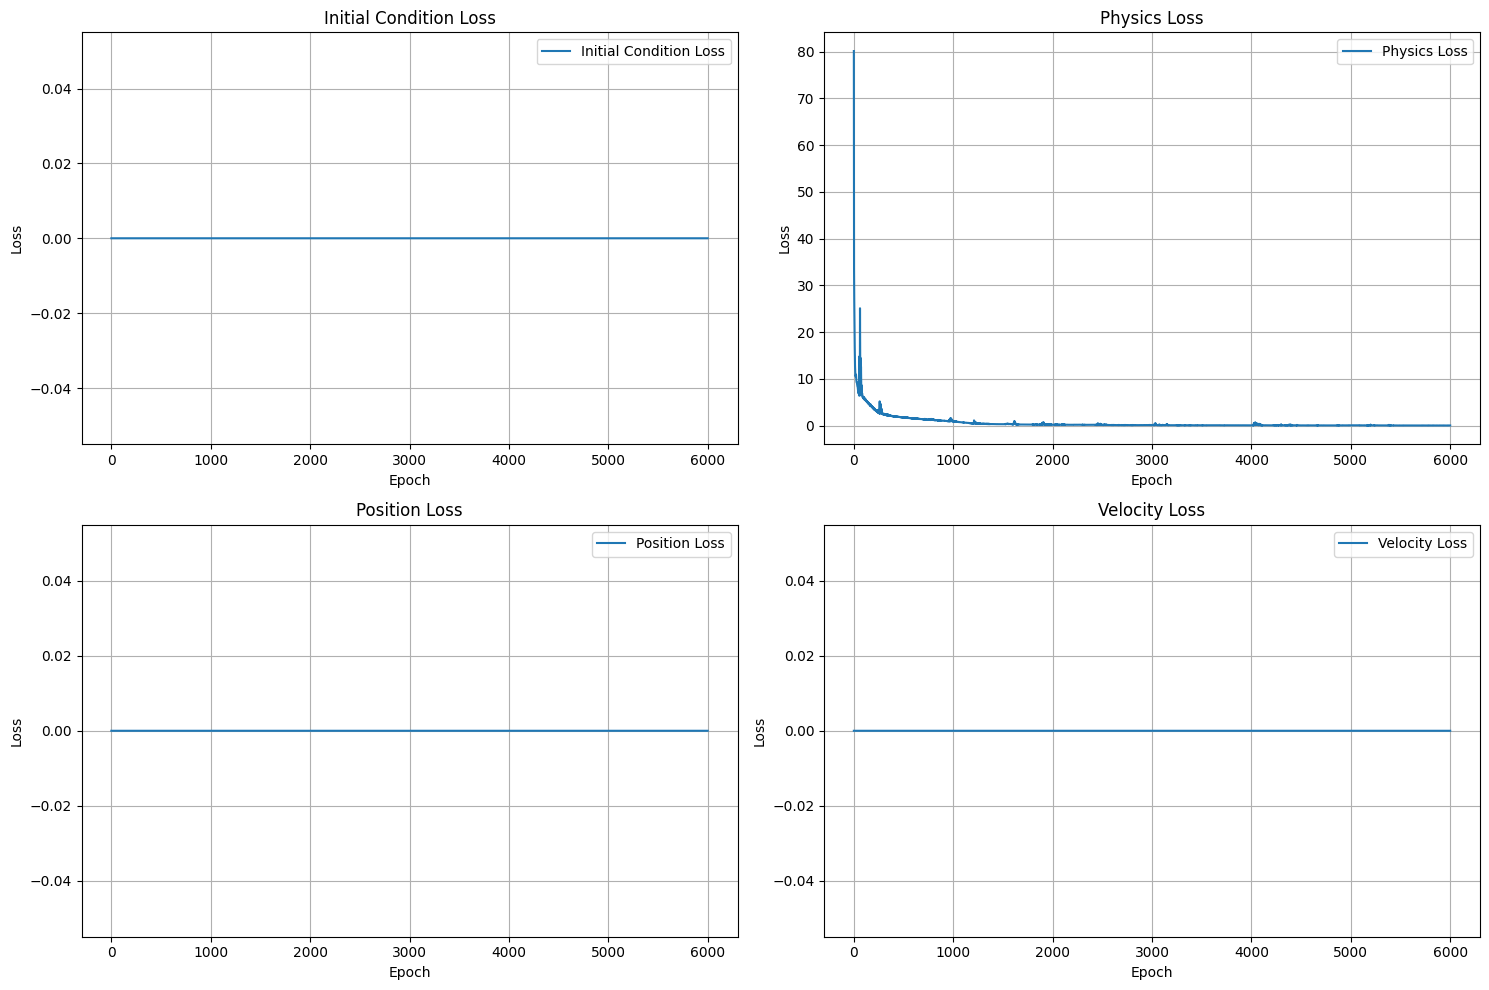

In [125]:
print("=== 結果檢查 ===")

X_0_tensor = torch.tensor([THETA_0, PHI_0, PSI_0], dtype=torch.float32).to(DEVICE)
D_X_0_tensor = torch.tensor([D_THETA_0, D_PHI_0, D_PSI_0], dtype=torch.float32).to(DEVICE)

time_test = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True).to(DEVICE)
output_test = model(time_test)

print(f"期望初始位置: {X_0_tensor.cpu().numpy()}")
print(f"模型預測初始位置: {output_test.detach().cpu().numpy().flatten()}")

output_grad_theta_val = torch.autograd.grad(output_test[0,0], time_test, create_graph=True, retain_graph=True)[0].item()
output_grad_phi_val = torch.autograd.grad(output_test[0,1], time_test, create_graph=True, retain_graph=True)[0].item()
output_grad_psi_val = torch.autograd.grad(output_test[0,2], time_test, create_graph=True)[0].item()

predicted_velocity = torch.tensor([output_grad_theta_val, output_grad_phi_val, output_grad_psi_val], device=DEVICE)

print(f"期望初始速度: {D_X_0_tensor.cpu().numpy()}")
print(f"模型預測初始速度: {predicted_velocity.detach().cpu().numpy()}")

loss_data_array = np.array(loss_data)
print(f"\n最終Total Loss: {loss_data_array[-1, 1]:.6f}") # Total loss is just physics loss
#print(f"最終Initial Condition Loss: {loss_data_array[-1, 0]:.10f}")
#print(f"最終Physics Loss: {loss_data_array[-1, 1]:.10f}")
#print(f"最終Position Loss: {loss_data_array[-1, 2]:.10f}")
#print(f"最終Velocity Loss: {loss_data_array[-1, 3]:.10f}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_data_array[:, 0], label='Initial Condition Loss')
plt.title('Initial Condition Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(loss_data_array[:, 1], label='Physics Loss')
plt.title('Physics Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(loss_data_array[:, 2], label='Position Loss')
plt.title('Position Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(loss_data_array[:, 3], label='Velocity Loss')
plt.title('Velocity Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 繪製圖表

The solver successfully reached the end of the integration interval.


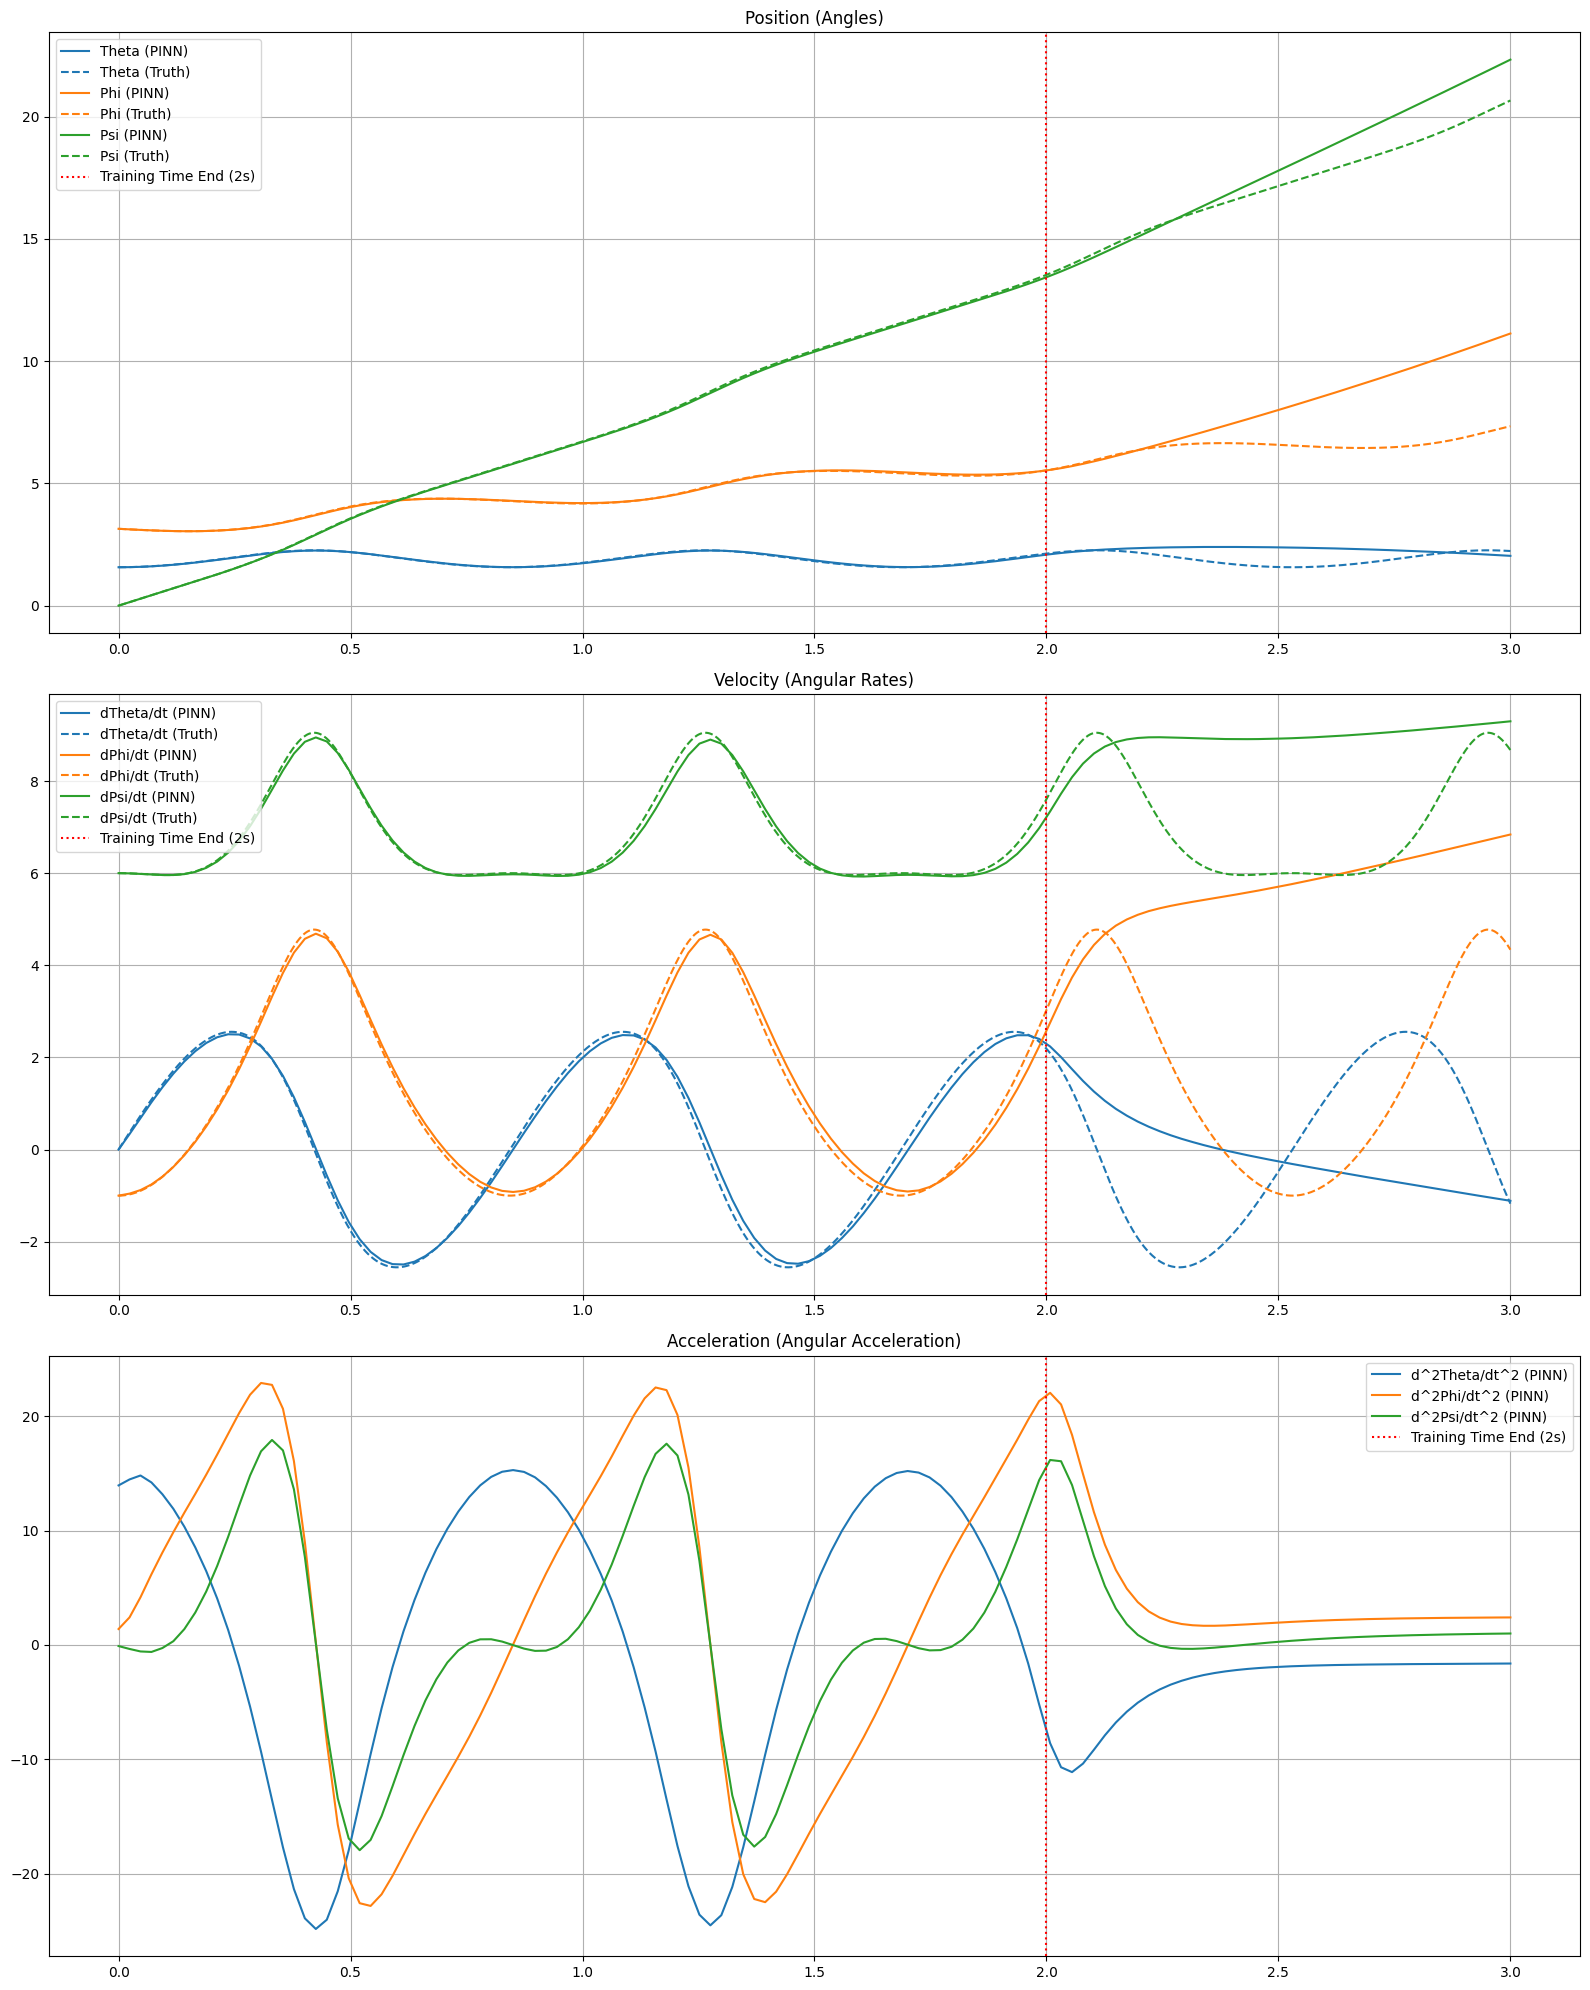

In [126]:
time = np.linspace(0, TOTAL_TIME + 1, BATCH_SIZE).reshape(-1, 1)
time = torch.tensor(time, dtype=torch.float32, requires_grad=True).to(DEVICE)

output = model(time)

output_gradient_theta = torch.autograd.grad(
    outputs=output[:,0],
    inputs=time,
    grad_outputs=torch.ones_like(output[:,0]),
    create_graph=True
)

output_grident_2_theta = torch.autograd.grad(
    outputs=output_gradient_theta[0],
    inputs=time,
    grad_outputs=torch.ones_like(output_gradient_theta[0]),
    create_graph=True
)

output_gradient_phi = torch.autograd.grad(
    outputs=output[:,1],
    inputs=time,
    grad_outputs=torch.ones_like(output[:,1]),
    create_graph=True
)

output_grident_2_phi = torch.autograd.grad(
    outputs=output_gradient_phi[0],
    inputs=time,
    grad_outputs=torch.ones_like(output_gradient_phi[0]),
    create_graph=True
)

output_gradient_psi = torch.autograd.grad(
    outputs=output[:,2],
    inputs=time,
    grad_outputs=torch.ones_like(output[:,2]),
    create_graph=True
)

output_grident_2_psi = torch.autograd.grad(
    outputs=output_gradient_psi[0],
    inputs=time,
    grad_outputs=torch.ones_like(output_gradient_psi[0]),
    create_graph=True
)

output_gradient = torch.cat((output_gradient_theta[0].unsqueeze(1), output_gradient_phi[0].unsqueeze(1), output_gradient_psi[0].unsqueeze(1)), dim=1).reshape(-1, 3)
output_gradient_2 = torch.cat((output_grident_2_theta[0].unsqueeze(1), output_grident_2_phi[0].unsqueeze(1), output_grident_2_psi[0].unsqueeze(1)), dim=1).reshape(-1, 3)

output_gradient = output_gradient.detach().cpu().numpy()
output_gradient_2 = output_gradient_2.detach().cpu().numpy()

time = time.detach().cpu().numpy()
output = output.detach().cpu().numpy()

time_sim = np.linspace(0, TOTAL_TIME + 1, 1000)

X_0 = np.array([THETA_0, PHI_0, PSI_0])
D_X_0 = np.array([D_THETA_0, D_PHI_0, D_PSI_0])
I = np.array([I_1, I_2, I_3])
# output_sim = real_word_simulation(time_sim, I, X_0, D_X_0)
output_sim = real_word_simulation_solve_ivp(time_sim, I, X_0, D_X_0, M, g, H)

plt.figure(figsize=(16, 20))

# Subplot 1: Position (Angles)
plt.subplot(3, 1, 1)
plt.plot(time, output[:, 0], label='Theta (PINN)', color='C0', linestyle='-')
plt.plot(time_sim, output_sim[:, 0], label='Theta (Truth)', color='C0', linestyle='--')
plt.plot(time, output[:, 1], label='Phi (PINN)', color='C1', linestyle='-')
plt.plot(time_sim, output_sim[:, 1], label='Phi (Truth)', color='C1', linestyle='--')
plt.plot(time, output[:, 2], label='Psi (PINN)', color='C2', linestyle='-')
plt.plot(time_sim, output_sim[:, 2], label='Psi (Truth)', color='C2', linestyle='--')
plt.axvline(x=TOTAL_TIME, color='red', linestyle=':', label=f'Training Time End ({TOTAL_TIME}s)')
plt.legend()
plt.grid()
plt.title("Position (Angles)")

# Subplot 2: Velocity (Angular Rates)
plt.subplot(3, 1, 2)
plt.plot(time, output_gradient[:, 0], label='dTheta/dt (PINN)', color='C0', linestyle='-')
plt.plot(time_sim, output_sim[:, 3], label='dTheta/dt (Truth)', color='C0', linestyle='--')
plt.plot(time, output_gradient[:, 1], label='dPhi/dt (PINN)', color='C1', linestyle='-')
plt.plot(time_sim, output_sim[:, 4], label='dPhi/dt (Truth)', color='C1', linestyle='--')
plt.plot(time, output_gradient[:, 2], label='dPsi/dt (PINN)', color='C2', linestyle='-')
plt.plot(time_sim, output_sim[:, 5], label='dPsi/dt (Truth)', color='C2', linestyle='--')
plt.axvline(x=TOTAL_TIME, color='red', linestyle=':', label=f'Training Time End ({TOTAL_TIME}s)')
plt.legend()
plt.grid()
plt.title("Velocity (Angular Rates)")

# Subplot 3: Acceleration (Angular Acceleration)
# Note: solve_ivp does not directly output acceleration, so we can't plot its ground truth here.
plt.subplot(3, 1, 3)
plt.plot(time, output_gradient_2[:, 0], label='d^2Theta/dt^2 (PINN)', color='C0', linestyle='-')
plt.plot(time, output_gradient_2[:, 1], label='d^2Phi/dt^2 (PINN)', color='C1', linestyle='-')
plt.plot(time, output_gradient_2[:, 2], label='d^2Psi/dt^2 (PINN)', color='C2', linestyle='-')
plt.axvline(x=TOTAL_TIME, color='red', linestyle=':', label=f'Training Time End ({TOTAL_TIME}s)')
plt.legend()
plt.grid()
plt.title("Acceleration (Angular Acceleration)")


plt.tight_layout()
plt.show()


=== 3D 軌跡繪圖 ===


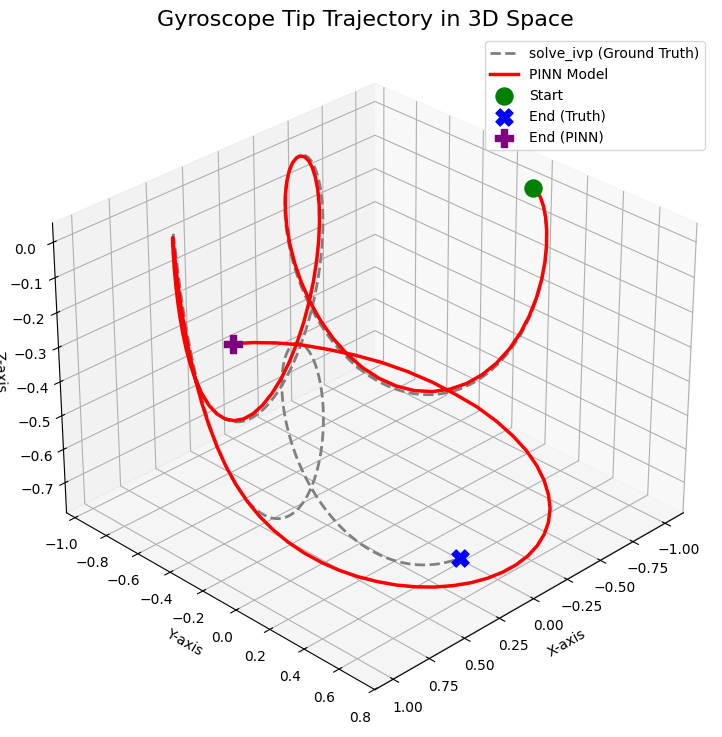

In [127]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

print("=== 3D 軌跡繪圖 ===")

if 'output' not in locals() or 'output_sim' not in locals():
    print("請先執行前面的儲存格來生成 'output' 和 'output_sim' 數據。")
else:
    L = 1.0

    theta_sim = output_sim[:, 0]
    phi_sim = output_sim[:, 1]

    x_sim = L * np.sin(theta_sim) * np.cos(phi_sim)
    y_sim = L * np.sin(theta_sim) * np.sin(phi_sim)
    z_sim = L * np.cos(theta_sim)

    theta_model = output[:, 0]
    phi_model = output[:, 1]

    phi_offset = phi_model[0] - phi_sim[0]
    phi_model_corrected = phi_model - phi_offset

    x_model = L * np.sin(theta_model) * np.cos(phi_model_corrected)
    y_model = L * np.sin(theta_model) * np.sin(phi_model_corrected)
    z_model = L * np.cos(theta_model)

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_sim, y_sim, z_sim, label='solve_ivp (Ground Truth)', color='gray', linestyle='--', linewidth=2)
    
    ax.plot(x_model, y_model, z_model, label='PINN Model', color='red', linewidth=2.5)

    ax.scatter(x_sim[0], y_sim[0], z_sim[0], color='green', s=150, label='Start', marker='o', depthshade=False)
    ax.scatter(x_sim[-1], y_sim[-1], z_sim[-1], color='blue', s=150, label='End (Truth)', marker='X', depthshade=False)
    ax.scatter(x_model[-1], y_model[-1], z_model[-1], color='purple', s=150, label='End (PINN)', marker='P', depthshade=False)

    ax.set_title("Gyroscope Tip Trajectory in 3D Space", fontsize=16)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.legend()
    ax.grid(True)
    
    ax.view_init(elev=30., azim=45)

    plt.show()
